# 1. Setup

#### Importing Libraries

In [ ]:
#importing important libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import json
import re
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Exploratory Data Analysis

In [ ]:
# Loading the dataset
file_path = "./preprocessed_df_symbolic_regression/train/train.csv"
data = pd.read_csv(file_path)

In [ ]:
# Display some info regarding the dataset
print("Dataset Head:\n", data.head())

Dataset Head:
      var_0    var_1    var_2  const_0  const_1  const_2   target
0 -1.38743 -3.13741 -4.48433      0.0      0.0      0.0 -0.62712
1 -3.65466  0.25221  1.18234      0.0      0.0      0.0  1.18414
2  3.51728 -4.73637 -0.39378      0.0      0.0      0.0 -0.80678
3 -4.18700 -1.28518 -3.06537      0.0      0.0      0.0 -0.63453
4  0.07286  1.56815 -0.50519      0.0      0.0      0.0  1.04786


In [5]:
print("\nDataset Info:\n")
data.info()


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74700 entries, 0 to 74699
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   var_0    74700 non-null  float64
 1   var_1    74700 non-null  float64
 2   var_2    74700 non-null  float64
 3   const_0  74700 non-null  float64
 4   const_1  74700 non-null  float64
 5   const_2  74700 non-null  float64
 6   target   74700 non-null  float64
dtypes: float64(7)
memory usage: 4.0 MB


In [6]:
print("\nSummary Statistics:\n", data.describe())


Summary Statistics:
               var_0         var_1         var_2       const_0       const_1  \
count  74700.000000  74700.000000  74700.000000  74700.000000  74700.000000   
mean       0.004088     -0.003044      0.012762      0.253089      0.029400   
std        2.891401      2.885149      2.894683      0.528536      0.196714   
min       -5.407720     -5.278530     -5.276140      0.000000      0.000000   
25%       -2.510102     -2.492435     -2.497410      0.000000      0.000000   
50%        0.002460     -0.017770      0.028080      0.000000      0.000000   
75%        2.518972      2.493667      2.521870      0.000000      0.000000   
max        5.197520      5.217490      5.271110      1.996860      1.997410   

            const_2        target  
count  74700.000000  7.470000e+04  
mean       0.002077 -2.431736e+04  
std        0.056730  4.897236e+06  
min        0.000000 -1.021394e+09  
25%        0.000000 -5.217100e-01  
50%        0.000000  5.890650e-01  
75%        0.0

In [ ]:
# Checking for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 var_0      0
var_1      0
var_2      0
const_0    0
const_1    0
const_2    0
target     0
dtype: int64


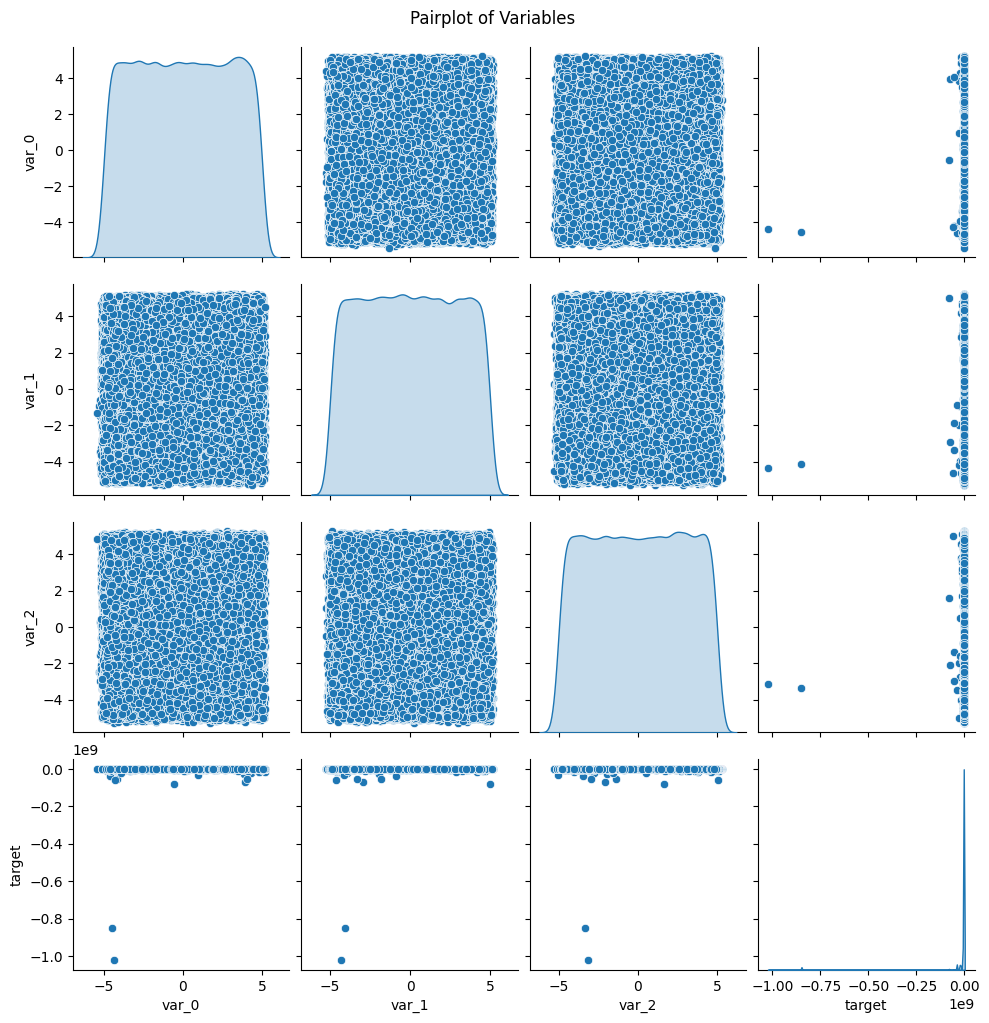

In [ ]:
# Pairplot for visualizing relationships
sns.pairplot(data, vars=["var_0", "var_1", "var_2", "target"], diag_kind="kde")
plt.suptitle("Pairplot of Variables", y=1.02)
plt.show()

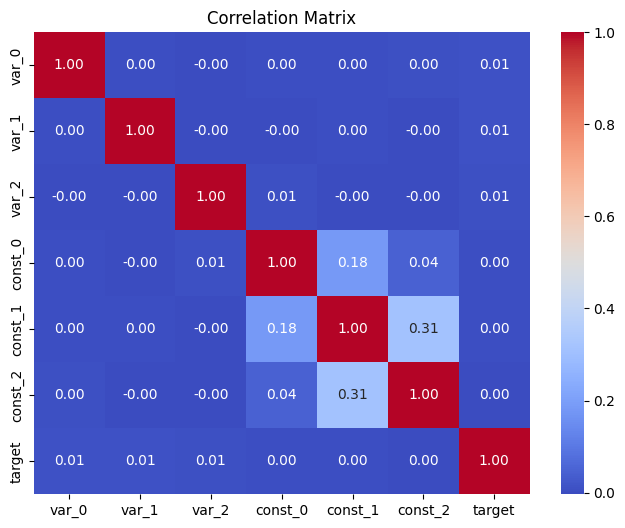

In [ ]:
# correlation matrix figure
correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

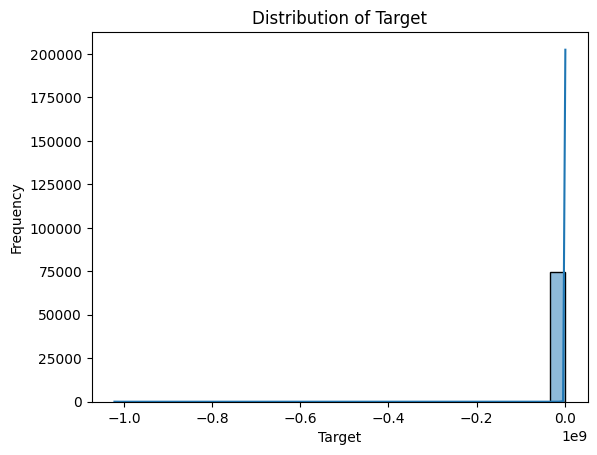

In [ ]:
# This is the variable distribution
# plt.figure(figsize=(8, 5))
sns.histplot(data["target"], kde=True, bins=30)
plt.title("Distribution of Target")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.show()

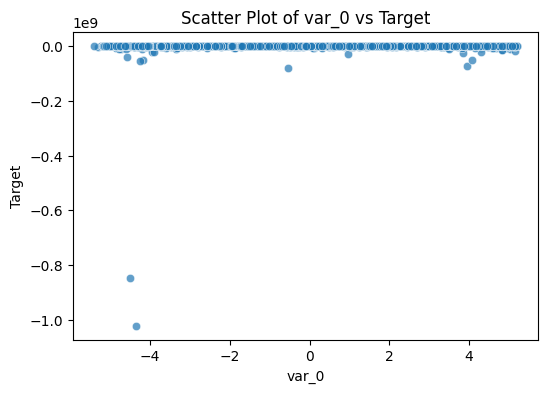

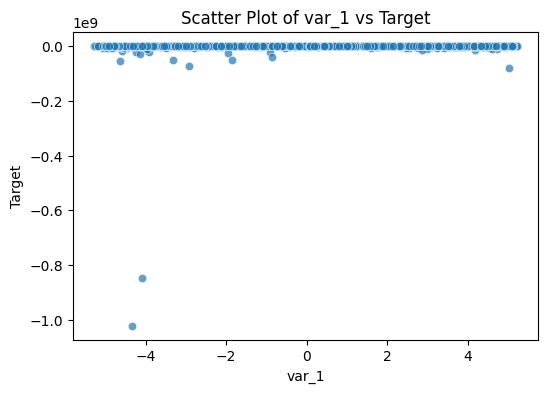

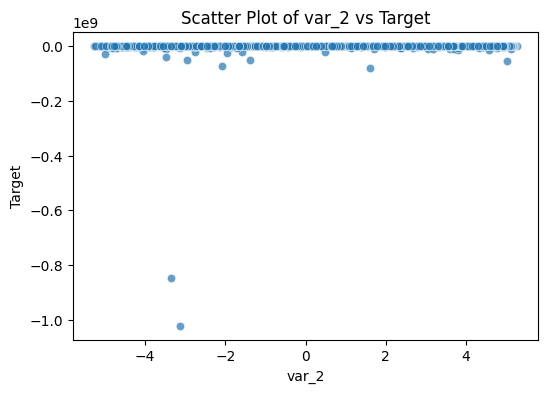

In [ ]:
# This is the scatter plots for relationships with target
for var in ["var_0", "var_1", "var_2"]:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=data[var], y=data["target"], alpha=0.7)
    plt.title(f"Scatter Plot of {var} vs Target")
    plt.xlabel(var)
    plt.ylabel("Target")
    plt.show()

In [ ]:
constant_columns = [col for col in data.columns if "const" in col]
constant_values = data[constant_columns].nunique()
print("\nConstant Columns Analysis:\n", constant_values)


Constant Columns Analysis:
 const_0    186
const_1     22
const_2      2
dtype: int64


# 3. Preprocessing Data

In [ ]:
def tokenize_formula(formula):
    token_pattern = r"[a-zA-Z_][a-zA-Z0-9_]*|[()+\-*/]|\d+\.?\d*"
    tokens = re.findall(token_pattern, formula)
    return tokens

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder_path = "data_symbolic_regression/train"
val_folder_path = "data_symbolic_regression/val"

# Loading and tokenizing formulas from the training set
tokenized_formulas = []
points_list = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable = data.get("formula_human_readable", "")
            if formula_human_readable:
                tokens = tokenize_formula(formula_human_readable)
                tokenized_formulas.append(tokens)
            
            points = data.get("points")
            if points:
                points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)  
                points_list.append(points_tensor)

val_tokenized_formulas = []
val_points_list = []

# Initiating vocabulary from tokens
for file_name in os.listdir(val_folder_path):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(val_folder_path, file_name)
        with open(file_path, "r") as file:
            val_data = json.load(file)

            val_formula_human_readable = val_data.get("formula_human_readable", "")
            if val_formula_human_readable:
                val_tokens = tokenize_formula(val_formula_human_readable)
                val_tokenized_formulas.append(val_tokens)
            
            val_points = val_data.get("points")
            if val_points:
                val_points_array = np.array([val_points["var_0"], val_points["var_1"], val_points["var_2"], val_points["target"]])
                val_points_tensor = torch.tensor(val_points_array, dtype=torch.float32, device=device).unsqueeze(0) 
                val_points_list.append(val_points_tensor)

all_tokenized_formulas = tokenized_formulas + val_tokenized_formulas

In [ ]:
vocab_mapping = {token: idx for idx, token in enumerate(set(t for tokens in all_tokenized_formulas for t in tokens))}
vocab_size = len(vocab_mapping)

# EOS and PAD token IDs
eos_token_id = vocab_size  
pad_token_id = vocab_size + 1  

# Adding EOS and PAD tokens to vocab_mapping
if eos_token_id not in vocab_mapping.values():
    vocab_mapping['<EOS>'] = eos_token_id
if pad_token_id not in vocab_mapping.values():
    vocab_mapping['<PAD>'] = pad_token_id

vocab_size = len(vocab_mapping)

In [ ]:
# Tokenize and map tokens (vocabulary indices)
token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in tokenized_formulas]

# Calculate sequence length 
formula_lengths = [len(tokens) for tokens in tokenized_formulas]
seq_len = int(np.percentile(formula_lengths, 100)) + 1 
batch_size = 100 

# Pad or truncate sequences
token_sequences = [
    seq[:seq_len] + [eos_token_id] + [pad_token_id]*max(0, seq_len - len(seq)) 
    if len(seq) < seq_len else seq[:seq_len] + [eos_token_id]  
    for seq in token_sequences
]

token_tensor = torch.tensor(token_sequences, device=device)
token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in token_sequences]
token_tensor = torch.tensor(token_sequences, device=device)

In [ ]:
# Tokenize and map tokens (vocabulary indices)
val_token_sequences = [[vocab_mapping.get(token, pad_token_id) for token in tokens] for tokens in val_tokenized_formulas]

# Calculate sequence length
val_formula_lengths = [len(tokens) for tokens in val_tokenized_formulas]
val_seq_len = int(np.percentile(val_formula_lengths, 100)) 

# Pad or truncate sequences
val_token_sequences = [
    seq[:seq_len] + [eos_token_id] + [pad_token_id]*max(0, seq_len - len(seq)) 
    if len(seq) < seq_len else seq[:seq_len] + [eos_token_id] 
    for seq in val_token_sequences
]

val_token_tensor = torch.tensor(val_token_sequences, device=device)
val_token_sequences = [seq[:seq_len] + [0] * max(0, seq_len - len(seq)) for seq in val_token_sequences]
val_token_tensor = torch.tensor(val_token_sequences, device=device)

# 4. Model Architecture

In [ ]:
@dataclass
class tNetConfig:
    num_vars: int
    embedding_size: int

class tNet(nn.Module):
    def __init__(self, config: tNetConfig):
        super(tNet, self).__init__()

        self.config = config
        self.num_vars = config.num_vars
        self.n_embd = config.embedding_size

        self.activation_func = F.relu

        self.conv1 = nn.Conv1d(self.num_vars + 1, self.n_embd, 1)
        self.conv2 = nn.Conv1d(self.n_embd, 2 * self.n_embd, 1)
        self.conv3 = nn.Conv1d(2 * self.n_embd, 4 * self.n_embd, 1)

        self.fc1 = nn.Linear(4 * self.n_embd, 2 * self.n_embd)
        self.fc2 = nn.Linear(2 * self.n_embd, self.n_embd)

        self.input_batch_norm = nn.GroupNorm(1, self.num_vars + 1)

        self.bn1 = nn.GroupNorm(1, self.n_embd)
        self.bn2 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn3 = nn.GroupNorm(1, 4*self.n_embd)
        self.bn4 = nn.GroupNorm(1, 2*self.n_embd)
        self.bn5 = nn.GroupNorm(1, self.n_embd)

    def forward(self, x):
      
        x = self.input_batch_norm(x)
        x = self.activation_func(self.bn1(self.conv1(x)))
        x = self.activation_func(self.bn2(self.conv2(x)))
        x = self.activation_func(self.bn3(self.conv3(x)))
        x, _ = torch.max(x, dim=2)  
        assert x.size(1) == 4 * self.n_embd

        x = self.activation_func(self.bn4(self.fc1(x)))
        x = self.activation_func(self.bn5(self.fc2(x)))

        return x

class TextDiffusionModel:
    def __init__(self, vocab_size, seq_len, device="cpu"):
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.device = device
        # self.noise_schedule = torch.linspace(0.01, 0.1, steps=1000).to(device)  
        self.noise_schedule = torch.linspace(1e-4, 2e-2, steps=1000).to(device)  

    def add_noise(self, tokens, t):
        noise_std = self.noise_schedule[t].view(-1, 1, 1)  

        # Converting tokens (one-hot vectors)
        one_hot = F.one_hot(tokens.long(), num_classes=self.vocab_size).float()
        
        # Adding Gaussian noise 
        noise = torch.randn_like(one_hot) * noise_std
        noisy_one_hot = one_hot + noise

        # Compute softmax 
        noisy_tokens = F.softmax(noisy_one_hot, dim=-1)
        return noisy_tokens, noise

    def sample_from_noisy_tokens(self, noisy_tokens):
        sampled_tokens = torch.argmax(noisy_tokens, dim=-1)
        return sampled_tokens

class ReverseProcessModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_vars, seq_len):
        super(ReverseProcessModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.num_vars = num_vars
        self.seq_len = seq_len

        # Calculate the correct input size for fc1
        input_size = embedding_size + (seq_len * vocab_size) + 1  

        # Construct the layers for the reverse process model
        self.fc1 = nn.Linear(input_size, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, seq_len * vocab_size)  

    def forward(self, noisy_tokens, embeddings, t):
        noisy_tokens_flat = noisy_tokens.view(noisy_tokens.size(0), -1)

        # Combine embeddings, flattened noisy tokens, and timestep information
        timestep_embedding = torch.cat([embeddings, noisy_tokens_flat, t.unsqueeze(1).float()], dim=-1)
        
        # Process through the fully connected layers
        x = F.relu(self.fc1(timestep_embedding))
        x = F.relu(self.fc2(x))
        predicted_noise = self.fc3(x)
        predicted_noise = predicted_noise.view(-1, self.seq_len, self.vocab_size)
        
        return predicted_noise

In [ ]:
diffusion_model = TextDiffusionModel(vocab_size, seq_len, device=device)

# Choose random timesteps
t = torch.randint(0, 1000, (len(token_tensor),), device=device)

# Adding noise to the tokens
noisy_tokens, noise = diffusion_model.add_noise(token_tensor, t)
sampled_tokens = diffusion_model.sample_from_noisy_tokens(noisy_tokens)

# Configuration for tNet
num_vars = 3
embedding_size = 128  
config = tNetConfig(num_vars=num_vars, embedding_size=embedding_size)

tnet_model = tNet(config)
batch_size = 1

# Generate embeddings
output_embeddings = []
for pt in points_list:
    output_embedding = tnet_model(pt)
    output_embeddings.append(output_embedding)

points_tensors = torch.cat(points_list, dim=0)

output_embeddings_tensor = torch.cat(output_embeddings, dim=0)
# Print the output
print("Input shape:", points_tensors.shape)
print("Output shape:", output_embeddings_tensor.shape)

# Print results
print("Original Tokens shape:", token_tensor.shape)
print("Noisy Tokens (probabilities) shape:", noisy_tokens.shape)
print("Sampled Tokens shape:", sampled_tokens.shape)


Input shape: torch.Size([747, 4, 100])
Output shape: torch.Size([747, 128])
Original Tokens shape: torch.Size([747, 28])
Noisy Tokens (probabilities) shape: torch.Size([747, 28, 25])
Sampled Tokens shape: torch.Size([747, 28])


# 5. Training and Validation Loop

In [ ]:
reverse_model = ReverseProcessModel(vocab_size, embedding_size, num_vars, seq_len).to(device)

# Cross-entropy loss function
loss_fn = nn.CrossEntropyLoss()
epochs = 1000  
batch_size = 100  

# Optimizer 
optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-4)
#optimizer = torch.optim.AdamW(reverse_model.parameters(), lr=1e-4, weight_decay=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=2,factor=0.5)

# Early stopping 
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0
training_losses = []
validation_losses = []

In [ ]:
for epoch in range(epochs):
    reverse_model.train()
    total_loss = 0

    for batch_idx in range(0, len(points_list), batch_size):
        batch_points = points_list[batch_idx:batch_idx + batch_size]
        batch_token_tensor = token_tensor[batch_idx:batch_idx + batch_size]

        t_batch = torch.randint(0, 1000, (len(batch_points),), device=device)

        # Add noise
        noisy_tokens, _ = diffusion_model.add_noise(batch_token_tensor, t_batch)

        # Get embeddings
        batch_embeddings = [tnet_model(pt) for pt in batch_points]
        embeddings_tensor = torch.cat(batch_embeddings, dim=0)

        logits = reverse_model(noisy_tokens, embeddings_tensor, t_batch)

        # Reshape logits 
        logits_flat = logits.view(-1, vocab_size)
        target_tokens = batch_token_tensor.view(-1)
        loss = loss_fn(logits_flat, target_tokens)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation Phase
    reverse_model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch_idx in range(0, len(val_points_list), batch_size):
            val_batch_points = val_points_list[val_batch_idx:val_batch_idx + batch_size]
            val_batch_token_tensor = val_token_tensor[val_batch_idx:val_batch_idx + batch_size]

            val_t_batch = torch.randint(0, 1000, (len(val_batch_points),), device=device)

            val_noisy_tokens, _ = diffusion_model.add_noise(val_batch_token_tensor, val_t_batch)

            val_embeddings = [tnet_model(pt) for pt in val_batch_points]
            val_embeddings_tensor = torch.cat(val_embeddings, dim=0)

            val_logits = reverse_model(val_noisy_tokens, val_embeddings_tensor, val_t_batch)
            val_logits_flat = val_logits.view(-1, vocab_size)
            val_target_tokens = val_batch_token_tensor.view(-1)

            val_loss += loss_fn(val_logits_flat, val_target_tokens).item()

    val_loss /= len(val_points_list)

    training_losses.append(total_loss/len(points_list))
    validation_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {training_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

    #scheduler.step(val_loss)
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(reverse_model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered. Restoring best model...")
        reverse_model.load_state_dict(torch.load('best_model.pth'))
        break

Epoch [1/1000], Loss: 0.0427, Val Loss: 0.0412
Epoch [2/1000], Loss: 0.0314, Val Loss: 0.0327
Epoch [3/1000], Loss: 0.0264, Val Loss: 0.0295
Epoch [4/1000], Loss: 0.0240, Val Loss: 0.0270
Epoch [5/1000], Loss: 0.0219, Val Loss: 0.0252
Epoch [6/1000], Loss: 0.0206, Val Loss: 0.0237
Epoch [7/1000], Loss: 0.0199, Val Loss: 0.0239
Epoch [8/1000], Loss: 0.0194, Val Loss: 0.0219
Epoch [9/1000], Loss: 0.0187, Val Loss: 0.0214
Epoch [10/1000], Loss: 0.0182, Val Loss: 0.0209
Epoch [11/1000], Loss: 0.0180, Val Loss: 0.0210
Epoch [12/1000], Loss: 0.0178, Val Loss: 0.0206
Epoch [13/1000], Loss: 0.0172, Val Loss: 0.0203
Epoch [14/1000], Loss: 0.0169, Val Loss: 0.0196
Epoch [15/1000], Loss: 0.0168, Val Loss: 0.0198
Epoch [16/1000], Loss: 0.0164, Val Loss: 0.0191
Epoch [17/1000], Loss: 0.0162, Val Loss: 0.0192
Epoch [18/1000], Loss: 0.0161, Val Loss: 0.0189
Epoch [19/1000], Loss: 0.0161, Val Loss: 0.0188
Epoch [20/1000], Loss: 0.0160, Val Loss: 0.0187
Epoch [21/1000], Loss: 0.0159, Val Loss: 0.0187
E

C:\Users\matth\AppData\Local\Temp\ipykernel_44040\3912563837.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reverse_model.load_state_dict(torch.load('best_model.pth'))

# 6. Training Results

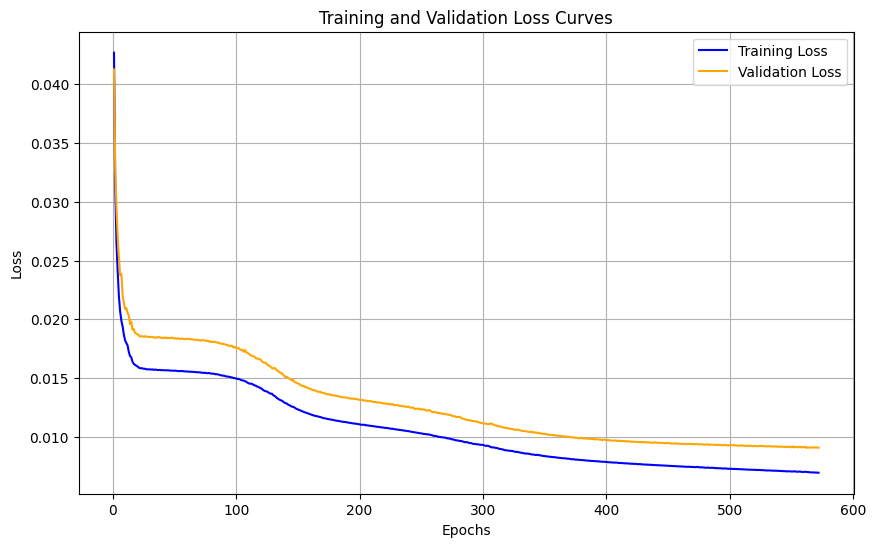

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# 7. Evaluate Model

In [ ]:
def evaluate_diffusion_model(test_folder, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device):
    reverse_vocab_mapping = {idx: token for token, idx in vocab_mapping.items()}

    results = []

    for file_name in os.listdir(test_folder):
        if file_name.endswith(".json") and not file_name.startswith('properties'):
            file_path = os.path.join(test_folder, file_name)

            with open(file_path, "r") as file:
                data = json.load(file)

                formula_human_readable = data.get("formula_human_readable", "")
                tokens = tokenize_formula(formula_human_readable)
                token_indices = [vocab_mapping.get(token, 0) for token in tokens]
                token_indices = token_indices[:seq_len] + [0] * max(0, seq_len - len(token_indices))
                token_tensor = torch.tensor(token_indices, device=device).unsqueeze(0)  

                points = data.get("points")
                if points:
                    points_array = np.array([points["var_0"], points["var_1"], points["var_2"], points["target"]])
                    points_tensor = torch.tensor(points_array, dtype=torch.float32, device=device).unsqueeze(0)

                    # Generate embeddings using tNet model
                    embedding = tnet_model(points_tensor)
                    t = torch.randint(0, 1000, (1,), device=device)
                    noisy_tokens, _ = diffusion_model.add_noise(token_tensor, t)
                    reconstructed_noise = reverse_model(noisy_tokens, embedding, t)
                    # reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1).squeeze(0)

                    # Ensuring that the reconstructed_tokens is a list
                    reconstructed_tokens = torch.argmax(reconstructed_noise, dim=-1)
                    if reconstructed_tokens.dim() == 2:  
                        reconstructed_tokens = reconstructed_tokens.squeeze(0)  
                    elif reconstructed_tokens.dim() == 1:  
                        pass  
                    else:
                        raise ValueError(f"Unexpected shape for reconstructed_tokens: {reconstructed_tokens.shape}")

                    reconstructed_formula = "".join(
                        reverse_vocab_mapping[idx] if idx in reverse_vocab_mapping else "<UNK>" for idx in reconstructed_tokens.tolist()
                    )
                    
                    reconstructed_formula = reconstructed_formula.replace("<EOS>", "").replace("<PAD>", "")
                    
                    actual_formula = "".join(tokens)

                    results.append((actual_formula, reconstructed_formula))
    return results

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

folder_path_test = "data_symbolic_regression/test"

tokenized_formulas_test = []
points_list_test = []

for file_name in os.listdir(folder_path_test):
    if file_name.endswith(".json") and not file_name.startswith('properties'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "r") as file:
            data = json.load(file)

            formula_human_readable_test = data.get("formula_human_readable", "")
            if formula_human_readable_test:
                tokens_test = tokenize_formula(formula_human_readable_test)
                tokenized_formulas_test.append(tokens_test)
                
            points_test = data.get("points")
            if points_test:
                points_array_test = np.array([points_test["var_0"], points_test["var_1"], points_test["var_2"], points_test["target"]])
                points_tensor_test = torch.tensor(points_array_test, dtype=torch.float32, device=device).unsqueeze(0) 
                points_list_test.append(points_tensor_test)

results = evaluate_diffusion_model(folder_path_test, diffusion_model, reverse_model, tnet_model, vocab_mapping, seq_len, device)

example_idx = 11

if results:
    actual, reconstructed = results[example_idx]
    print(f"Actual Formula: {actual}")
    print(f"Reconstructed Formula: {reconstructed}")

Actual Formula: (((var_2*C_0)*cos(var_1))*gaussian(reverse(var_0)))
Reconstructed Formula: (((var_0+C_0)+sqrt(var_1)))gaussian(((var_2)))


# 8. Evaluation Results

### BLEU Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calBleu(results):
    total_bleu = 0
    smoothing = SmoothingFunction().method1

    for actual_formula, reconstructed_formula in results:
        # Tokenize using the same function as the main code
        reference = [tokenize_formula(actual_formula)]
        candidate = tokenize_formula(reconstructed_formula)

        # Compute BLEU score 
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
        total_bleu += bleu_score

    average_bleu = total_bleu / len(results) if results else 0
    return average_bleu

In [ ]:
average_bleu = calBleu(results)

In [30]:
average_bleu

0.24547235219006663

### Token similarity

In [ ]:
def cal_token_acc(results):
    total_tokens = 0
    correct_tokens = 0

    for actual_formula, reconstructed_formula in results:
        actual_tokens = tokenize_formula(actual_formula)
        reconstructed_tokens = tokenize_formula(reconstructed_formula)

        # Count matching tokens
        total_tokens += len(actual_tokens)
        correct_tokens += sum(1 for a, r in zip(actual_tokens, reconstructed_tokens) if a == r)

    token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    return token_accuracy

In [ ]:
token_accuracy = cal_token_acc(results)

In [33]:
token_accuracy

0.6066730830927174

### Edit Distance

In [ ]:
from nltk.metrics import edit_distance

def editDistance(results):
    total_distance = 0

    for actual_formula, reconstructed_formula in results:
        actual_tokens = tokenize_formula(actual_formula)
        reconstructed_tokens = tokenize_formula(reconstructed_formula)

        # Computing edit distance between tokenized formulas
        total_distance += edit_distance(actual_tokens, reconstructed_tokens)

    average_distance = total_distance / len(results) if results else 0
    return average_distance

In [ ]:
edit_distance = editDistance(results)

In [37]:
edit_distance

7.217391304347826